# File Organiser for LTMP GoPRO

This script will walk you through three steps to:
1) Sort images: This step organises all the images from the Left (LC) and Right (RC) cameras, in a given Reef folder, into subfolders using a time gap to distinguish transects and sites. Then, it automatically recognises the QR codes in the images and rename transect subfolders for each camera folder.
2) Manually review subfolder names and allocate names to those where QR was not recognised
3) Automatically merge subfolders from Left and Right Camera

## SET UP

In [5]:
from pyzbar import pyzbar
import argparse
import cv2, os, datetime
import exifread
import pandas as pd, numpy as np
import shutil
from tqdm import tqdm, notebook
from time import sleep


# mypath="E:3d_ltmp/data/LTMP/201920/RAP/QA/arlington reef/LC"
rootpath="E:3d_ltmp/data/LTMP/201920/RAP/QA/arlington reef/"
img_rename='ARLINGTON REEF_V28'
QRmap=pd.read_csv("C:/Users/mgonzale/Documents/gits/misc_manu/QRmap.csv")


## STEP 1: Sort images, QR scan and rename subdirectories

In [34]:

# SORT IMAGES
cameras=['RC','LC']
for c in notebook.tnrange(2, desc='Sorting images per camera'):
    camera=cameras[c]
    mypath=os.path.join(rootpath,camera)
    imdf=pd.DataFrame({'filename':[],'DateTime':[]})
    count=0
    for imgname in os.listdir(mypath):
        if imgname.endswith(".JPG"):
            ##Organise images by time
            count=count+1
            fh=open(os.path.join(mypath,imgname), 'rb')
            tags = exifread.process_file(fh, stop_tag="EXIF DateTimeOriginal")
            iminfo=pd.DataFrame({'filename':[os.path.join(mypath,imgname)], 
                                 'DateTime': [datetime.datetime.strptime(str(tags["EXIF DateTimeOriginal"]),
                                                                         '%Y:%m:%d %H:%M:%S')]})
            imdf=imdf.append(iminfo)

    # Move image cluster into subfolders
    imdf = imdf.sort_values("DateTime")
    cluster = (imdf["DateTime"].diff() > pd.Timedelta(minutes=3)).cumsum()
    dfs = [v for k,v in imdf.groupby(cluster)]
    i=0
    prefix=img_rename+'_'+camera+'_'
    for clust_idx in notebook.tnrange(len(dfs),desc='Creating transects', leave=False):
        clust=dfs[clust_idx]
        #ignore clusters where there is only a couple of images
        if len(clust)>5:
            i=i+1
            dest=os.path.join(mypath,str(i))
            if not os.path.exists(dest):
                os.mkdir(dest)
            clust.apply(lambda row: shutil.copy(row['filename'], os.path.join(dest,
                                                                              prefix+os.path.basename(row['filename']))), 
                        axis=1)


def imgTrans(img_path, method):    
    
    #Read image
    img=cv2.imread(os.path.join(mypath,g,imgname))

    #ALTERING IMAGE
    if method == 0:# orginal
        img=img
    elif method==1: # Changing colour to grey
        img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif method == 7: # Chaning luminosity by gamma transformation - Brighter
        gamma_table=[np.power(x/255.0,1.5)*255.0 for x in range(256)]
        gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
        img=cv2.LUT(img,gamma_table)
    elif method == 3: # Chaning luminosity by gamma transformation -Darker
        gamma_table=[np.power(x/255.0,0.5)*255.0 for x in range(256)]
        gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
        img=cv2.LUT(img,gamma_table)
    elif method == 4: #Binary Threshold
        img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        t=cv2.mean(img_grey)
        t=tuple(map(lambda x: isinstance(x, float) and int(round(x, 0)) or x, t))
        ret,img=cv2.threshold(img_grey,t[0],255,cv2.THRESH_BINARY)
    elif method == 5: #OTSU Threshold
        img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        t=cv2.mean(img_grey)
        t=tuple(map(lambda x: isinstance(x, float) and int(round(x, 0)) or x, t))
        ret,img=cv2.threshold(img_grey,t[0],255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif method == 6: #UTSU Threhsold with a Gaussian Filter
        img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        t=cv2.mean(img_grey)
        t=tuple(map(lambda x: isinstance(x, float) and int(round(x, 0)) or x, t))
        blur = cv2.GaussianBlur(img_grey,(5,5),0)
        ret,img=cv2.threshold(img_grey,t[0],255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif method == 2: #Theshold inverted image
        mask = cv2.inRange(img,(0,0,0),(200,200,200))
        thresholded = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
        img = 255-thresholded # black-in-white
#     images=[img_grey,img1,img2,img3,img_highgamma,inverted]
#     titles=['org','Binary','OTSU','OTSU+Gaussian','inverted']
    
    return img

## Run QR code detection and rename subdirectoris
qrData=pd.DataFrame(columns=['Code','Folder', 'Camera'])
cameras=['RC','LC']
for c in notebook.tnrange(2, desc='Detecting QR codes'):
    camera=cameras[c]
    mypath=os.path.join(rootpath,camera)
    gdir = [dI for dI in os.listdir(mypath) if os.path.isdir(os.path.join(mypath,dI))]
    for gx in notebook.tnrange(len(gdir), desc='Scanning subdirectories',leave=False):
        g=gdir[gx]
        if os.path.isdir(os.path.join(mypath,g)):
    #         print("[STATUS]: Analysing Folder #: {}".format(g))
    #         iterator=tqdm(os.listdir(os.path.join(mypath,g))[0:5])
#             for imgname in notebook.tqdm(os.listdir(os.path.join(mypath,g))[0:5], desc="Folder #: {}".format(g),leave=True):
            check=0
            im=0
            while (check <1) & (im in range(5)):
                if len(os.listdir(os.path.join(mypath,g)))>10:
                    imgname=os.listdir(os.path.join(mypath,g))[im]
                    if imgname.endswith(tuple((".jpg",".JPG"))):
                        i=0
                        check2=0
                        while (check2 < 1) & (i in range(7)):
                            img=imgTrans(os.path.join(mypath,g,imgname), i)
                            barcodes = pyzbar.decode(img,symbols=[pyzbar.ZBarSymbol.QRCODE])
                            # loop over the detected barcodes
                            if len(barcodes) != 0:
                                for barcode in barcodes:
                                    barcodeData = barcode.data.decode("utf-8")
                                    barcodeType = barcode.type
                                    qrData=qrData.append({'Code': barcodeData,
                                                              'Folder': g,
                                                              'Camera':camera}, ignore_index=True)
                                check2 +=1
                            else:
                                check2=0
                            i +=1
                if check2==1:
                    check +=1
                    newname=str(QRmap['Name'].loc[QRmap['Code']==int(barcodeData)].to_list()[0])
                    newname=g+'_'+newname
                    if not os.path.exists(os.path.join(mypath,newname)):
                        os.rename(os.path.join(mypath,g),os.path.join(mypath,newname))
                        
                im +=1


print('{} QR codes found in {} transects for the {} camera'.format(len(qrData['Code'].loc[qrData['Camera']=='RC']),
                                                            len(os.listdir(os.path.join(rootpath,'RC'))),
                                                            'RC'))
print('{} QR codes found in {} transects for the {} camera'.format(len(qrData['Code'].loc[qrData['Camera']=='LC']),
                                                            len(os.listdir(os.path.join(rootpath,'LC'))),
                                                            'LC'))

print('[IMPORTANT]: Please rename transect folders before continue. Use suggestiongs from QR scaner to rename all folders')


9 QR codes found in 1935 transects for the RC camera
7 QR codes found in 1965 transects for the LC camera
[IMPORTANT]: Please rename transect folders before continue. Use suggestiongs from QR scaner to rename all folders


## STEP 2: Manual renaming of transect folders
After the automation of QR scanning, it is possible that not all codes are recognised. Hence, the script above, kept the sequential numbering of the folders and inserted the Site#Tran# for those where the code was recognised. The original sequencial numbering was kept, so you know there other in which the images were taken. This should make it easier to rename those that were not named after the QR code scanning (i.e., filling the gaps).

After renaming those, please remove the numbers from the other folders, so we keep the folders exactly how we need them. For example:
* Site1Tran1
*Site2Tran1
*...


## STEP 3: Merge renamed transect folders from each camera

In [51]:
cameras=['RC','LC']
for c in notebook.tnrange(len(cameras), desc='Moving camera files'):
    camera=cameras[c]
    mypath=os.path.join(rootpath,camera)
    gdir = [dI for dI in os.listdir(mypath) if os.path.isdir(os.path.join(mypath,dI))]
    for tidx in notebook.tnrange(len(gdir), desc='Working within transects', leave=True):
        t=gdir[tidx]
        newfolder= os.path.join(rootpath,t)
        if not os.path.exists(newfolder):
            os.mkdir(newfolder)
        for basename in os.listdir(os.path.join(mypath,t)):
            if basename.endswith(tuple((".jpg",".JPG"))):
                pathname = os.path.join(os.path.join(mypath,t,basename))
            if os.path.isfile(pathname):
                shutil.move(pathname, newfolder)
        os.rmdir(os.path.join(mypath,t))
        
##Summarise results

In [42]:
cameras=['RC','LC']
for c in notebook.tnrange(len(cameras), desc='Moving camera files'):
    camera=cameras[c]
    mypath=os.path.join(rootpath,camera)
    gdir = [dI for dI in os.listdir(mypath) if os.path.isdir(os.path.join(mypath,dI))]
    for t in notebook.tnrange(len(gdir), desc='sorting transects'):
        trans=gdir[t]
        dest=os.path.join(rootpath, trans)
        if os.path.exists(dest):
            os.mkdir(dest)
        for basename in os.listdir(trans):
                if basename.endswith('.JPG'):
                    pathname = os.path.join(srcdir, basename)
                if os.path.isfile(pathname):
                    shutil.copy2(pathname, dstdir)
        

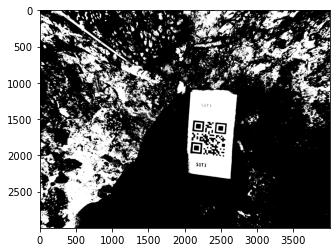

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

##
img_path="E:3d_ltmp/data/LTMP/201920/RAP/QA/arlington reef/LC/G0018203.JPG"
def imgTrans(img_path, method):    
    
    #Read image
    img=cv2.imread(os.path.join(mypath,g,imgname))

    #ALTERING IMAGE
    if method == 0:# orginal
        img=img
    elif method==1: # Changing colour to grey
        img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif method == 7: # Chaning luminosity by gamma transformation - Brighter
        gamma_table=[np.power(x/255.0,1.5)*255.0 for x in range(256)]
        gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
        img=cv2.LUT(img,gamma_table)
    elif method == 3: # Chaning luminosity by gamma transformation -Darker
        gamma_table=[np.power(x/255.0,0.5)*255.0 for x in range(256)]
        gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
        img=cv2.LUT(img,gamma_table)
    elif method == 4: #Binary Threshold
        img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        t=cv2.mean(img_grey)
        t=tuple(map(lambda x: isinstance(x, float) and int(round(x, 0)) or x, t))
        ret,img=cv2.threshold(img_grey,t[0],255,cv2.THRESH_BINARY)
    elif method == 5: #OTSU Threshold
        img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        t=cv2.mean(img_grey)
        t=tuple(map(lambda x: isinstance(x, float) and int(round(x, 0)) or x, t))
        ret,img=cv2.threshold(img_grey,t[0],255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif method == 6: #UTSU Threhsold with a Gaussian Filter
        img_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        t=cv2.mean(img_grey)
        t=tuple(map(lambda x: isinstance(x, float) and int(round(x, 0)) or x, t))
        blur = cv2.GaussianBlur(img_grey,(5,5),0)
        ret,img=cv2.threshold(img_grey,t[0],255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif method == 2: #Theshold inverted image
        mask = cv2.inRange(img,(0,0,0),(200,200,200))
        thresholded = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
        img = 255-thresholded # black-in-white
#     images=[img_grey,img1,img2,img3,img_highgamma,inverted]
#     titles=['org','Binary','OTSU','OTSU+Gaussian','inverted']
    
    return img

img=imgTrans(img_path,7)
plt.imshow(img)
# mask = cv2.inRange(img,(0,0,0),(200,200,200))
# thresholded = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
# inverted = 255-thresholded # black-in-white
#plt.imshow(inverted)

range(6)

In [17]:
range(5)[0]

0